___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>
# RNN Example for Time Series

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [2]:
df = pd.read_csv('Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

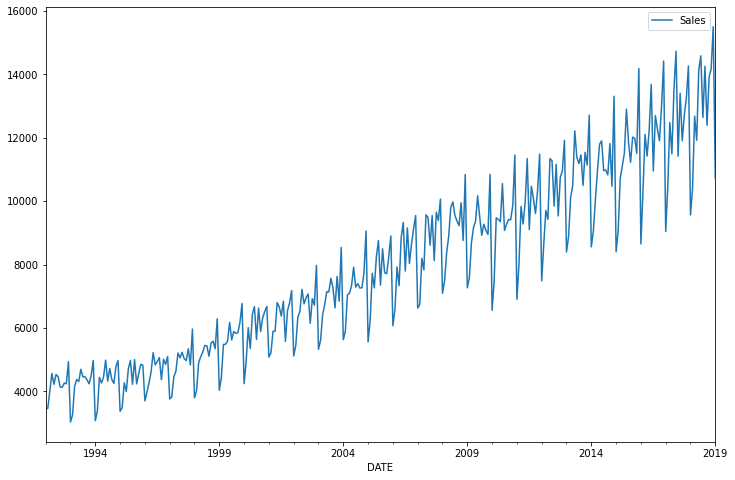

In [5]:
df.plot(figsize=(12,8))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='DATE'>

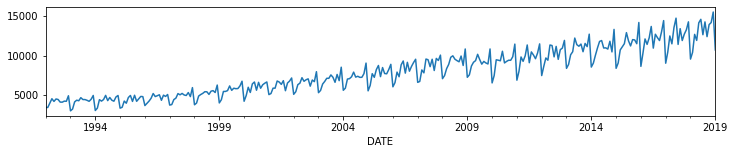

In [7]:
results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(12,2))

<AxesSubplot:xlabel='DATE'>

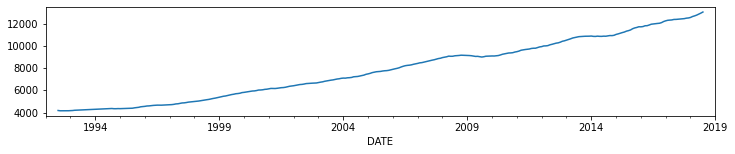

In [8]:
results.trend.plot(figsize=(12,2))

<AxesSubplot:xlabel='DATE'>

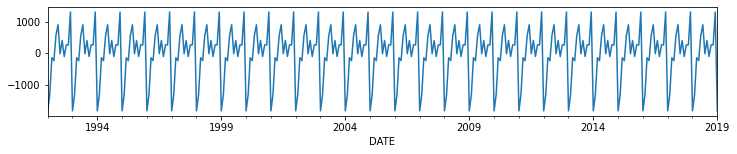

In [9]:
results.seasonal.plot(figsize=(12,2))

<AxesSubplot:xlabel='DATE'>

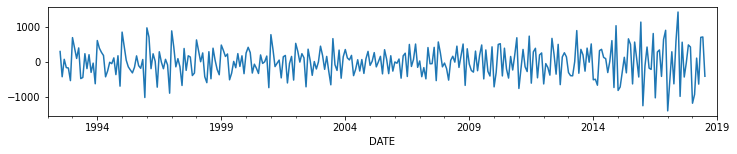

In [10]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [11]:
len(df)

325

In [12]:
325-12

313

In [13]:
train = df.iloc[:313]
test = df.iloc[313:]

In [14]:
len(test)

12

## Scale Data

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [19]:
import tensorflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
len(scaled_train)

313

In [23]:
len(generator) # n_input = 2

311

In [25]:
# What does the first batch look like?
X,y = generator[0]

In [26]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885]
Predict this y: 
 [[0.08299855]]


In [31]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [28]:
# What does the first batch look like?
X,y = generator[0]

In [29]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
Predict this y: 
 [[0.]]


### Create the Model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [36]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
# fit model
model.fit_generator(generator,epochs=50)

C:\Users\marziyeh\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
301/301 [==============================] - 7s 9ms/step - loss: 0.0172
Epoch 2/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0095
Epoch 3/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0097
Epoch 4/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0082
Epoch 5/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0075A: 0s - l
Epoch 6/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0062
Epoch 7/50
301/301 [==============================] - 2s 8ms/step - loss: 0.0056
Epoch 8/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0039
Epoch 9/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0039
Epoch 10/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0029
Epoch 11/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0026
Epoch 12/50
301/301 [==============================] - 3s 8ms/step - loss: 0.0028
Epoch 13/50
301/

In [ ]:
model.history.history.keys()

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

In [39]:
first_eval_batch = scaled_train[-12:]

In [40]:
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [41]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [42]:
model.predict(first_eval_batch)

array([[0.69323623]], dtype=float32)

In [43]:
scaled_test[0]

array([0.63116506])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [44]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [45]:
current_batch.shape

(1, 12, 1)

In [46]:
current_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [47]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.80776135],
        [ 0.72313873],
        [ 0.89870929],
        [ 1.        ],
        [ 0.71672793],
        [ 0.88648602],
        [ 0.75869732],
        [ 0.82742115],
        [ 0.87443371],
        [ 0.96025301],
        [ 0.5584238 ],
        [99.        ]]])

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [48]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [49]:
test_predictions

[array([0.69323623], dtype=float32),
 array([0.832431], dtype=float32),
 array([0.79178125], dtype=float32),
 array([0.958091], dtype=float32),
 array([1.0285975], dtype=float32),
 array([0.7756988], dtype=float32),
 array([0.92895836], dtype=float32),
 array([0.7879489], dtype=float32),
 array([0.87144744], dtype=float32),
 array([0.9163393], dtype=float32),
 array([0.99861526], dtype=float32),
 array([0.59478664], dtype=float32)]

In [50]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

## Inverse Transformations and Compare

In [51]:
true_predictions = scaler.inverse_transform(test_predictions)

In [52]:
true_predictions

array([[11141.17067587],
       [12769.61048371],
       [12294.0488047 ],
       [14239.70684981],
       [15064.56184947],
       [12105.90003908],
       [13898.8838113 ],
       [12249.21425623],
       [13226.06364691],
       [13751.25321591],
       [14713.79998398],
       [ 9989.40894794]])

In [53]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [54]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\marziyeh\AppData\Local\Temp\ipykernel_8108\1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [55]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,11141.170676
2018-03-01,12683,12769.610484
2018-04-01,11919,12294.048805
2018-05-01,14138,14239.706850
2018-06-01,14583,15064.561849
2018-07-01,12640,12105.900039
2018-08-01,14257,13898.883811
2018-09-01,12396,12249.214256
2018-10-01,13914,13226.063647


In [ ]:
test.plot(figsize=(12,8))

# Saving and Loading Models

In [ ]:
model.save('my_rnn_model.h5')

## load a model

In [ ]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [ ]:
new_model.summary()